To practice skills learnt during the predictive inference unit, we will take the role of a person working for a real estate company in India. Our company is interested in understanding the rent prices of different houses to inform their decisions. To do so, we use the company's data containing rental listings with key attributes such as house size (square feet), rent price, and point of contact (agent, owner, builder).

Our goal is to analyze and predict rent prices by developing statistical models. We will first implement a simple model using only size as a predictor, then improve it using log-transformed rent and categorical variables. Finally, we will evaluate our models' performances by applying K-fold cross-validation to compare estimated MSE against true test-set MSE. Finally, we will take part in real-world examples of how our models can be presented and used in the company.

# Part I: Data Analysis

**Libraries and data set-up**

In [2]:
# Install package if not already installed
if (!require(zip)) install.packages("zip", dependencies = TRUE)

# Load the library
library(zip)

Loading required package: zip


Attaching package: ‘zip’


The following objects are masked from ‘package:utils’:

    unzip, zip




We extract our data available in our personal GitHub repository.

In [3]:
url <- "https://github.com/bruno-alv/cs130spring2025/raw/refs/heads/main/dataset.zip"
zip_file <- "dataset.zip"
download_dir <- "dataset"

# Download the ZIP file
download.file(url, zip_file, mode = "wb")

# Extract the ZIP file
unzip(zip_file, exdir = download_dir)

# Verify the extracted files
list.files(download_dir)

[1] "Dataset Glossary.txt"   "House_Rent_Dataset.csv"

**Data description**

In [4]:
# Load the dataset
dataset <- read.csv(file.path(download_dir, "House_Rent_Dataset.csv"))


cat("The dataframe is ",dim(dataset)[1]," entries and has ",dim(dataset)[2], "variables.")

# Quick check
head(dataset)

The dataframe is  4746  entries and has  12 variables.

,Posted.On,BHK,Rent,Size,Floor,Area.Type,Area.Locality,City,Furnishing.Status,Tenant.Preferred,Bathroom,Point.of.Contact
,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>
1,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
2,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
4,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
5,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner
6,2022-04-29,2,7000,600,Ground out of 1,Super Area,Thakurpukur,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner


In [5]:
# Identify categorical and numerical variables
cat_columns <- c("Posted.On","Floor", "Area.Type", "Area.Locality", "City", 
                 "Furnishing.Status", "Tenant.Preferred", "Point.of.Contact")
num_columns <- c("BHK", "Rent", "Size", "Bathroom")

# Convert categorical variables to character if needed
dataset[cat_columns] <- lapply(dataset[cat_columns], as.character)

# Create summary for categorical variables: Unique category count
cat_summary <- data.frame(
  Variable = cat_columns,
  Type = "Categorical",
  Unique_Categories = sapply(dataset[cat_columns], function(x) length(unique(x))),
  Mean = NA, Min = NA, Max = NA  # Not applicable for categorical variables
)

# Create summary for numerical variables: Mean, Min, Max
num_summary <- data.frame(
  Variable = num_columns,
  Type = "Numerical",
  Unique_Categories = NA,  # Not applicable for numerical variables
  Mean = sapply(dataset[num_columns], mean, na.rm = TRUE),
  Min = sapply(dataset[num_columns], min, na.rm = TRUE),
  Max = sapply(dataset[num_columns], max, na.rm = TRUE)
)

# Combine both tables
variable_summary <- rbind(cat_summary, num_summary)

# Print final table
print(variable_summary)

                           Variable        Type Unique_Categories         Mean
Posted.On                 Posted.On Categorical                81           NA
Floor                         Floor Categorical               480           NA
Area.Type                 Area.Type Categorical                 3           NA
Area.Locality         Area.Locality Categorical              2235           NA
City                           City Categorical                 6           NA
Furnishing.Status Furnishing.Status Categorical                 3           NA
Tenant.Preferred   Tenant.Preferred Categorical                 3           NA
Point.of.Contact   Point.of.Contact Categorical                 3           NA
BHK                             BHK   Numerical                NA     2.083860
Rent                           Rent   Numerical                NA 34993.451327
Size                           Size   Numerical                NA   967.490729
Bathroom                   Bathroom   Numerical     

As described in the dataframe above, we have 12 variables. 8 are categorical and 4 are numeric.

For this type of problem, we could try predictive or causal analysis approaches. We would focus on forecasting values using available data for a predictive approach. For instance, we can ask, "What is the rent price based on house size, number of bedrooms, or furnishing status?" or "Given a size and a rent price, how many rooms can we expect to have?"

On the other hand, causal questions would explore existing cause-and-effect relationships between variables. For example, we can ask, "Does having a balcony significantly increase rental prices?" or "Does a certain locality cause higher rents?"

Both approaches answer valuable questions about rent prices in our data set. Nevertheless, they differ as the conclusions we can draw from data analysis vary depending on the approach.

## Predictive Analysis

Firstly, we build a linear regression model to predict rent based only on house size.

In [6]:
# Split dataset into training (80%) and testing (20%) as this is the conventionality
set.seed(123)
split <- sample(1:nrow(dataset), 0.8 * nrow(dataset))
train <- dataset[split, ]
test <- dataset[-split, ]

In [7]:
# Build a simple linear regression model
simple_model <- lm(Rent ~ Size, data = train)

# View model summary
summary(simple_model)


Call:
lm(formula = Rent ~ Size, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-192424  -23398   -8781    9711 3386887 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -13846.160   2230.535  -6.208 5.96e-10 ***
Size            50.784      1.929  26.324  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 75320 on 3794 degrees of freedom
Multiple R-squared:  0.1544,	Adjusted R-squared:  0.1542 
F-statistic: 692.9 on 1 and 3794 DF,  p-value: < 2.2e-16


In [24]:
# Predict rent on training set
train_pred <- predict(simple_model, newdata = train)

# Predict rent on test set
test_pred <- predict(simple_model, newdata = test)

# Calculate Mean Squared Error (MSE)
mse_train <- mean((train$Rent - train_pred)^2)
mse_test <- mean((test$Rent - test_pred)^2)

# Print results
print(paste("Training MSE:", mse_train))
print(paste("Test MSE:", mse_test))
print(paste("Test and Train MSE difference:", mse_test - mse_train))

[1] "Training MSE: 5514871207.07362"
[1] "Test MSE: 3223888488.13353"
[1] "Test and Train MSE difference: -2290982718.94009"


**Model analysis**

The training error (MSE) is much higher than the test error, as shown above. The test MSE is commonly expected to be slightly higher than the training MSE as it is unseen data to the model, and the model is biased towards the training data. Therefore, such a high difference could imply that the model is underfitting the data.

Therefore, this model is simple to use as it simply needs us to know a house's size to determine the rent price. So, it could be helpful to our company as a quick estimation heuristic. Nevertheless, it will not be as practical as we have already determined that it is underfitting to the data.

To make the model more practical, we should explore the possibility that rent prices might depend on other factors. For instance, other variables in our dataset, such as location, number of bedrooms, and furnishing status, capture other factors relevant to pricing. Finally, we can also explore the possibility that the relationship between size and price is non-linear. Therefore, a simple linear regression might not accurately capture this possibility.

The coefficient for Size tells us how much Rent changes per unit increase in Size. In this case, for each unit increase in Size, we see a 50.78 unit increase in the rent price. For instance, for a 100 square feet larger house, Rent would, on average, be about 5,078 Rupees higher.

Additionally, the p-value for Size is < 2e-16, which is extremely small compared to our conventional threshold of 0.05. This indicates that the effect of Size on Rent is highly statistically significant. This suggests that there is strong evidence that Size is a meaningful predictor for Rent.

Furthermore, the Multiple R-squared is 0.1544. This means that this model reduces the mean squared prediction error by about 15.44% of the mean squared prediction error relative to a model with no predictors. In practical terms, using Size alone as a predictor explains 15.44% of the error reduction compared to simply predicting the average Rent for all houses.

Finally, even though Size is statistically significant, as evidenced by its very low p-value, the Multiple R-squared suggests that Size alone does not capture all the variability of Rent as there is still about 84% error to be explained. This confirms our suspicion that additional predictors would likely improve the model's predictive power.

**Further data analysis**

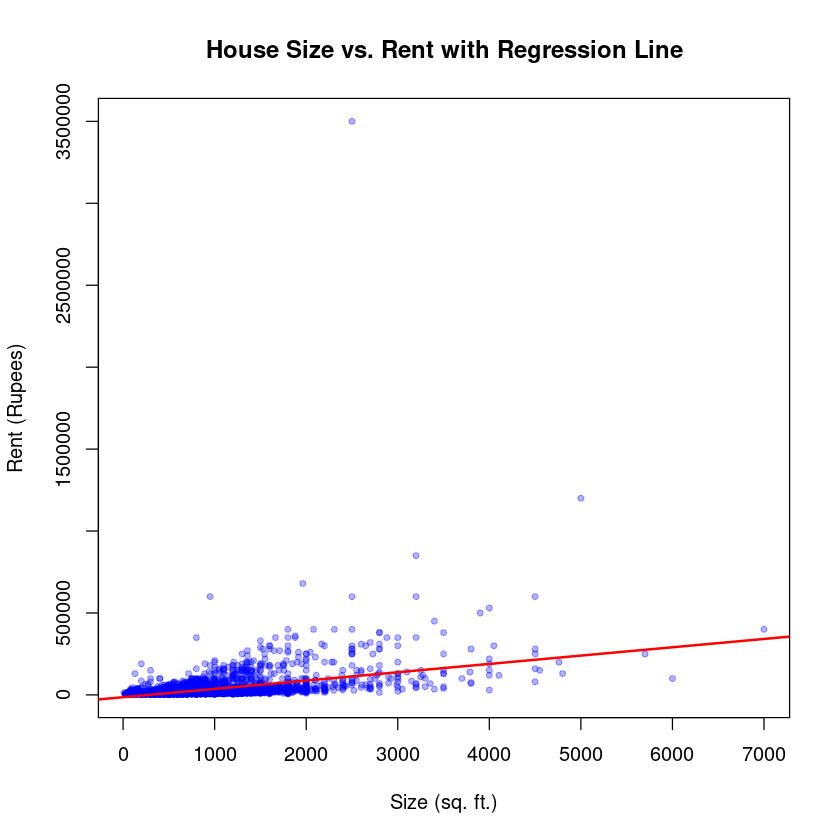

In [26]:
# Scatter plot of actual Size vs. Rent
plot(train$Size, train$Rent, pch=20, col=rgb(0, 0, 1, 0.3), 
     main="House Size vs. Rent with Regression Line",
     xlab="Size (sq. ft.)", ylab="Rent (Rupees)")

# Add regression line from the model
abline(simple_model, col="red", lwd=2)

From the plot, we see that there is indeed somewhat of an upward trend that our model also captures. Nevertheless, there seems to be an extreme outlier for a house of around 2,500 sq. ft. Additionally, the data appears to be heteroscedastic as the more significant the houses get, the more their rents vary. These factors seem to be affecting our simple model, as we have already seen a high level of underfitting.

**Filter data as an improvement**

We will repeat our analysis, but we will remove data on houses with Rent larger than 1 million Rupees.

In [157]:
# Create a filtered dataset
dataset_filtered <- dataset[dataset$Rent <= 1000000, ]

# Split dataset again into training (80%) and testing (20%) as this is conventional.
set.seed(123)
split <- sample(1:nrow(dataset_filtered), 0.8 * nrow(dataset_filtered))
train_filtered <- dataset_filtered[split, ]
test_filtered <- dataset_filtered[-split, ]

In [28]:
# Build a new regression model on the filtered dataset
model_filtered <- lm(Rent ~ Size, data = train_filtered)

# View the summary of the new model
summary(model_filtered)


Call:
lm(formula = Rent ~ Size, data = train_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-150212  -21095   -9042    7602  876186 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -8093.174   1417.029  -5.711 1.21e-08 ***
Size           43.051      1.236  34.833  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 47380 on 3793 degrees of freedom
Multiple R-squared:  0.2424,	Adjusted R-squared:  0.2422 
F-statistic:  1213 on 1 and 3793 DF,  p-value: < 2.2e-16


In [156]:
# Predict rent on the new training set
train_pred_filtered <- predict(model_filtered, newdata = train_filtered)

# Predict rent on the new test set
test_pred_filtered <- predict(model_filtered, newdata = test_filtered)

# Calculate Mean Squared Error (MSE) after outlier removal
mse_train_filtered <- mean((train_filtered$Rent - train_pred_filtered)^2)
mse_test_filtered <- mean((test_filtered$Rent - test_pred_filtered)^2)

# Print results
print(paste("Training MSE (Filtered):", mse_train_filtered))
print(paste("Test MSE (Filtered):", mse_test_filtered))
print(paste("Test and Train MSE difference:", mse_test_filtered - mse_train_filtered))

[1] "Training MSE (Filtered): 2244027227.5148"
[1] "Test MSE (Filtered): 3224471269.41914"
[1] "Test and Train MSE difference: 980444041.90434"


After removing extreme rent values, the Training MSE dropped significantly (from 5.67B to 2.24B), meaning the model now fits the houses' prices better. Additionally, the Test MSE is now higher than the Training MSE (+980M). This means that the model is less underfitting. This could also mean that the model is generalizing more as it fits the training data better.
Therefore, size alone is still not enough to predict rent accurately.

On the other hand, as the model now fits data much better, we can rely more on it in the firm to quickly estimate a house's price based on its size. Nevertheless, we cannot say it's accurate enough to make crucial decisions based solely on it.

Consequently, as the model fits the data better, the R-squared increased from 0.1544 to 0.2424. Therefore, this model reduces the mean squared prediction error by 24.24% relative to a model with no predictors. Furthermore, as we eliminated some houses with higher prices, the coefficient of Size slightly decreased (from 50.78 to 43.05). Nevertheless, the p-value remained <2e-16. This means that Size is still a highly significant predictor of Rent.

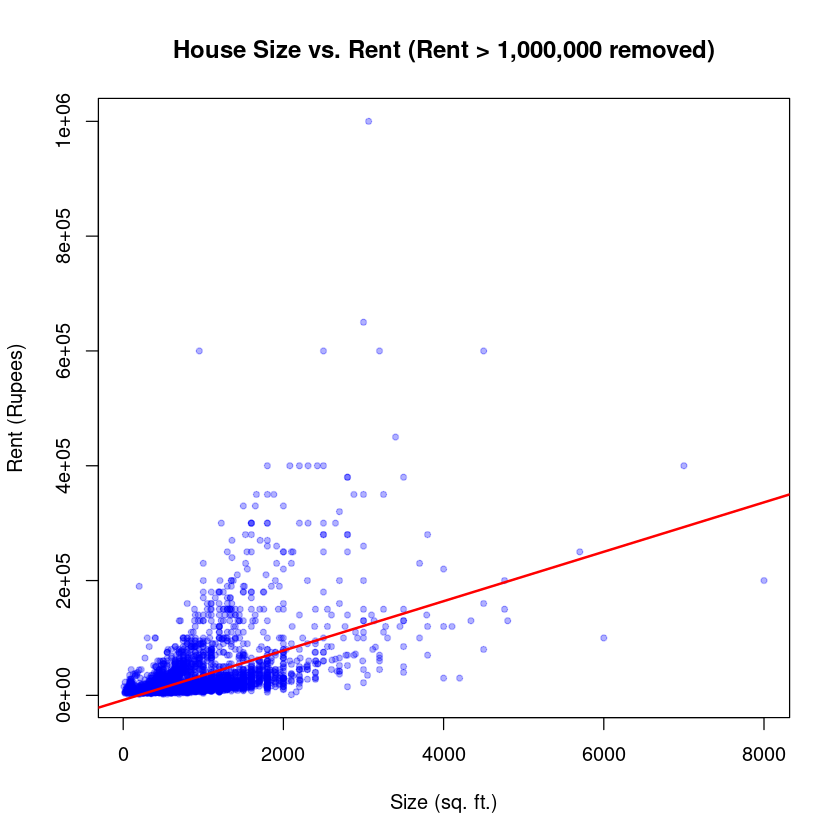

In [29]:
# Scatter plot of actual Size vs. Rent (filtered dataset)
plot(train_filtered$Size, train_filtered$Rent, pch=20, col=rgb(0, 0, 1, 0.3), 
     main="House Size vs. Rent (Rent > 1,000,000 removed)",
     xlab="Size (sq. ft.)", ylab="Rent (Rupees)")

# Add regression line from the filtered model
abline(model_filtered, col="red", lwd=2)

The scatter plot of our filtered data compared to its respective model still shows an upward price trend as size increases. This is captured by our red line representing the model we fit to the data. Nevertheless, this filtered data plot highlights the heteroscedasticity of the data as the more significant the house size, the more variability we perceive in the price.

Therefore, even if we remove outliers, our simple-one-predictor model still lacks the prediction power required to appropriately capture other predictors' influence, such as location or BHK, among others, on the rent price. So, we could eliminate the outliers to be more robust if we want to keep the size as a significant and accurate predictor. Nevertheless, we should keep the outlier, make our model more robust, and then assess if we should keep the outlier based on how well our improved models art. Lastly, eliminating the outlier based on its effect on the Size-dependent model does not explore the possibility of its high price being explained by other predictors. Therefore, we should keep it.

# Part II: Improving model

To improve the model, we can add a new predictor. We will add the variable Point of Contact. We will assess its impact and its effect on the Rent prices.

In [30]:
# Split dataset into training (80%) and testing (20%) as conventional and again to ensure we still have the right split.
set.seed(123)
split <- sample(1:nrow(dataset), 0.8 * nrow(dataset))
train <- dataset[split, ]
test <- dataset[-split, ]

# Build a new regression model with Point of Contact
model_poc <- lm(Rent ~ Size + Point.of.Contact, data = train)

# View summary of the new model
summary(model_poc)


Call:
lm(formula = Rent ~ Size + Point.of.Contact, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-185122  -18702   -3199    9336 3367197 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      24003.730   3035.345   7.908  3.4e-15 ***
Size                                43.520      1.901  22.898  < 2e-16 ***
Point.of.ContactContact Builder -35911.635  72470.907  -0.496     0.62    
Point.of.ContactContact Owner   -45444.990   2578.081 -17.627  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 72430 on 3792 degrees of freedom
Multiple R-squared:  0.2185,	Adjusted R-squared:  0.2179 
F-statistic: 353.3 on 3 and 3792 DF,  p-value: < 2.2e-16


It is worth noting that when adding the variable Point of Contact, we get two variables: one when the point of contact is the Owner and one when the point of contact is the Builder. This happens because this is a categorical variable. So, R automatically creates dummy variables for each category. However, when we analysed our data, we had three unique categories for the Point of Contact variable. After looking into the dataset's documentation, we noticed that the missing category is Agent. Since all entries have a point of contact, the Agent category's coefficient is the baseline intercept in our model. Therefore, we still have three categories; one seems omitted as it is not explicitly stated in the model's summary.

In [31]:
# Compute new training and test MSE
train_pred_poc <- predict(model_poc, newdata = train)
test_pred_poc <- predict(model_poc, newdata = test)

mse_train_poc <- mean((train$Rent - train_pred_poc)^2)
mse_test_poc <- mean((test$Rent - test_pred_poc)^2)

# Print results
print(paste("Training MSE (With Point of Contact):", mse_train_poc))
print(paste("Test MSE (With Point of Contact):", mse_test_poc))
print(paste("Test and Train MSE difference:", mse_test_poc - mse_train_poc))

[1] "Training MSE (With Point of Contact): 5240085157.15469"
[1] "Test MSE (With Point of Contact): 2311277885.85882"
[1] "Test and Train MSE difference: -2928807271.29587"


After removing the outliers in the Rent prices, we had an MSE of 2.6. Now, our MSE with the POC predictor decreased to 2.31B. This suggests that the model is slightly better at generalising as this reflects its performance in unseen data. Nevertheless, introducing a Point of Contact also leads to a negative Test-Train MSE difference (-2.93B). This means the model is underfitting the data, just like the initial simple model.

In [32]:
# Compare R-squared values
print(paste("R-squared (Simple initial Model without Point of Contact):", summary(simple_model)$r.squared))
print(paste("R-squared (Simple initial Model without Point of Contact or outliers):", summary(model_filtered)$r.squared))
print(paste("R-squared (Model with Point of Contact):", summary(model_poc)$r.squared))

[1] "R-squared (Simple initial Model without Point of Contact): 0.154434110950776"
[1] "R-squared (Simple initial Model without Point of Contact or outliers): 0.242360447434501"
[1] "R-squared (Model with Point of Contact): 0.21847448863829"


On the other hand, the original simple model had an R-squared of 0.1544, which slightly improved to 0.2424 on the model without outliers. Nevertheless, adding Point of Contact lowers the R-squared to 0.2185. This suggests that adding Point of Contact is not significantly improving the model, as the previous model was better at reducing the mean squared prediction error relative to a model with no predictors.

Therefore, because of the underfitting and the reduced R-squared, we can determine that adding this predictor did not improve our model much more compared to filtering the outliers out.

**Further improvements**

To further improve our model, we can look into our data's distribution.

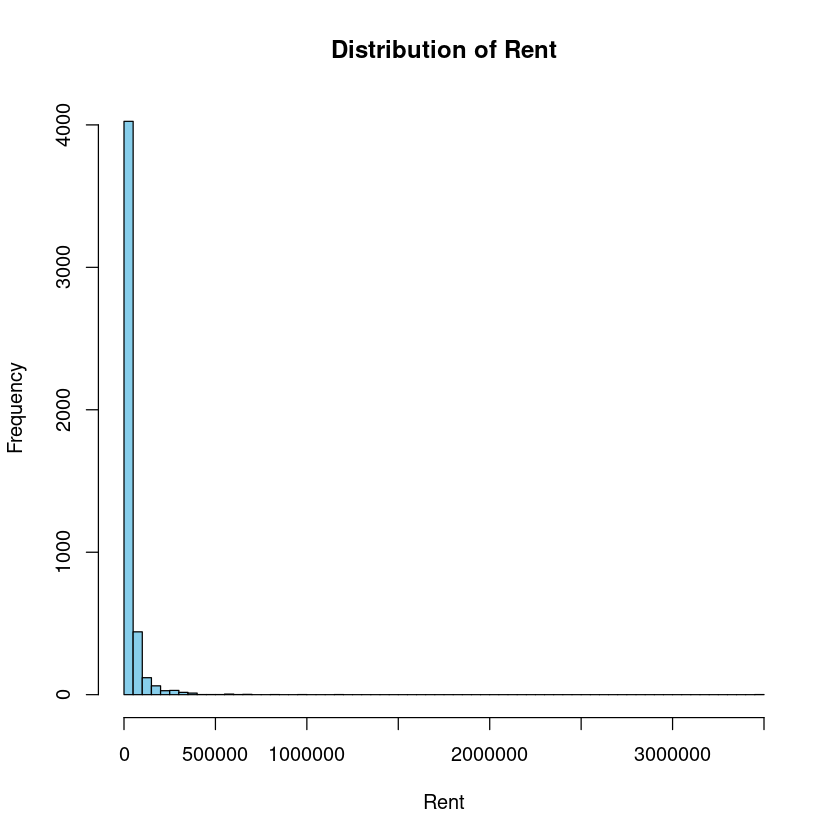

In [33]:
# Histogram of Rent
hist(dataset$Rent, breaks = 50, col = "skyblue", main = "Distribution of Rent", xlab = "Rent")

The plot above shows that the distribution is heavily skewed to the right. A linear regression attempts to predict the average data values. Therefore, more customarily distributed data fits it better. Consequently, we will transform the data. Our data is heteroscedastic, and a log transformation could help us achieve more normally distributed data. For instance, a log transformation compresses large values while spreading smaller values. Therefore, we should see our data distribution improve as, in previous plots, we saw low variability in small rent values and higher variability in higher values.

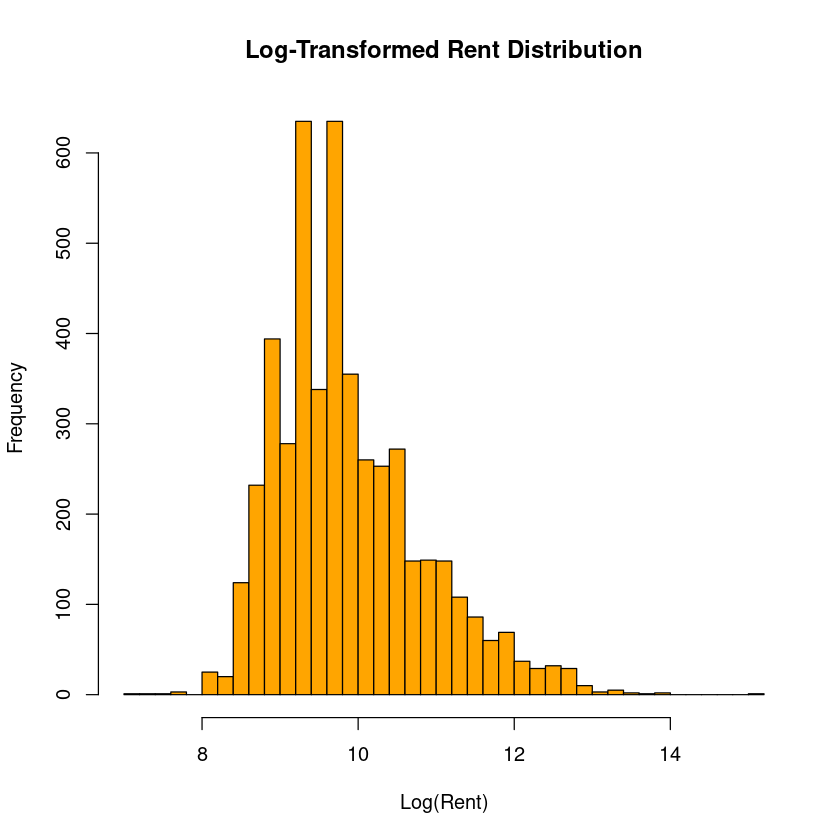

In [34]:
# Apply log transformation to Rent
dataset$Log_Rent <- log(dataset$Rent)

# Plot histogram of log-transformed Rent
hist(dataset$Log_Rent, breaks = 50, col = "orange", main = "Log-Transformed Rent Distribution", xlab = "Log(Rent)")

As we expected, the transformed data appears much more normally distributed although it still has a slight skew to the right. Now, we can run our regression analysis once more and assess if the transformation improved the model performance.

**Log-transformed-data model**

In [149]:
# Split dataset into training (80%) and testing (20%) as conventional.
split <- sample(1:nrow(dataset), 0.8 * nrow(dataset))
train <- dataset[split, ]
test <- dataset[-split, ]

# Build a new linear regression model with Log(Rent)
model_log <- lm(Log_Rent ~ Size + Point.of.Contact, data = train)

# View the summary of the log-transformed model
summary(model_log)


Call:
lm(formula = Log_Rent ~ Size + Point.of.Contact, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2161 -0.3907 -0.0548  0.3467  3.7709 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      9.909e+00  2.551e-02 388.429   <2e-16 ***
Size                             6.716e-04  1.568e-05  42.834   <2e-16 ***
Point.of.ContactContact Builder -1.565e+00  6.117e-01  -2.559   0.0105 *  
Point.of.ContactContact Owner   -1.013e+00  2.182e-02 -46.438   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6113 on 3792 degrees of freedom
Multiple R-squared:  0.5756,	Adjusted R-squared:  0.5753 
F-statistic:  1714 on 3 and 3792 DF,  p-value: < 2.2e-16


In [150]:
# Predict log(Rent) on training set
train_pred_log <- predict(model_log, newdata = train)

# Predict log(Rent) on test set
test_pred_log <- predict(model_log, newdata = test)

# Convert log predictions back to original scale
train_pred_log_exp <- exp(train_pred_log)
test_pred_log_exp <- exp(test_pred_log)

# Compute MSE for the log-transformed model
mse_train_log <- mean((train$Rent - train_pred_log_exp)^2)
mse_test_log <- mean((test$Rent - test_pred_log_exp)^2)

# Print results
print(paste("Training MSE (Log-Transformed Model):", mse_train_log))
print(paste("Test MSE (Log-Transformed Model):", mse_test_log))
print(paste("Test and Train MSE difference:", mse_test_log - mse_train_log))

[1] "Training MSE (Log-Transformed Model): 6843409659.71425"
[1] "Test MSE (Log-Transformed Model): 3041493735.77368"
[1] "Test and Train MSE difference: -3801915923.94057"


Compared to our best no-outliers-data model, the Test MSE decreased significantly from 3.2B to 1.16 B. This means the log-transformed model is better at predicting out-of-sample data more accurately. However, the Training MSE increased from 2.24 to 7.28, which suggests the model may be highly underfitting our training data. This is also reflected in the difference between the test and train MSE.

On the other hand, the same no-outlier model had an R-squared of 0.24. The new-log-transformed model improved the R-squared to 0.5868. This means that the log-data model reduces the mean squared prediction error by 58.68% relative to a model with no predictors. This is a significant improvement, especially compared to our previous models.

Therefore, although the model did not necessarily improve its predictive power, it proved to be much better at reducing the prediction error. Thus, this model does not address the main challenge of the rest about not using enough predictors, but the log transformation proves to be more effective at reducing the prediction error. Therefore, this approach did prove to be better, but we could still improve it by including more predictors.

**Cross-Validation**

We will use cross-validation to assess our overfitting and underfitting claims. We will use k-fold cross-validation and leave one out cross-validation. The following code is suitable for LOOCV and k-folds CV as LOOCV is just a special case of k-folds where k = n. We take a training set and split it into k individual sets. Leaving one of the k-folds at a time, we train the model on the rest of the data and use the left-out data as the test set. We can compute the MSE  using these sets. Finally, we will have k individual MSE. We can estimate the true test-set MSE by taking the average across them. 

In [151]:
# Define a function for flexible K-Fold Cross-Validation
k_fold_cv <- function(model_formula, data, k = 5) {
  n <- nrow(data)
  
  # If k = n, we are performing LOOCV
  if (k == n) {
    errors <- c()
    
    for (i in 1:n) {
      # Leave one observation out
      test_cv <- data[i, , drop = FALSE]
      train_cv <- data[-i, ]
      
      # Train model on training fold
      model <- lm(model_formula, data = train_cv)
      
      # Predict on left-out observation
      pred <- predict(model, newdata = test_cv)
      
      # Compute squared error
      mse <- (test_cv$Rent - pred)^2
      errors <- c(errors, mse)
    }
    
    # Return average MSE
    return(mean(errors))
    
  } else {
    # Standard K-Fold Cross-Validation
    fold_size <- floor(n / k)
    errors <- c()
    
    # Shuffle dataset
    set.seed(123)
    data <- data[sample(1:n), ]
    
    for (i in 1:k) {
      # Create test and train splits for each fold
      test_idx <- ((i - 1) * fold_size + 1):(i * fold_size)
      test_cv <- data[test_idx, ]
      train_cv <- data[-test_idx, ]
      
      # Train model on training fold
      model <- lm(model_formula, data = train_cv)
      
      # Predict on test fold
      preds <- predict(model, newdata = test_cv)
      
      # Compute Mean Squared Error (MSE)
      mse <- mean((test_cv$Rent - preds)^2)
      errors <- c(errors, mse)
    }
    
    # Return average MSE
    return(mean(errors))
  }
}

To ensure that we can perform our CV on our categorical data, we must ensure that our train and test datasets contain observations from all categories. Therefore, we will first separate each category, get individual 80% - 20% splits, and then assemble them to have our comprehensive train and test sets.

It is worth noting that upon further inspection, the Builder category in the Point of Contact variable only has one entry in the dataset. We could not use this for our cross-validation as we would need at least four entries to compare the folds against one another. Therefore, we will eliminate omit it from our analysis for now.

In [152]:
# Separate dataset by category
data_agent <- subset(dataset, Point.of.Contact == "Contact Agent")
data_owner <- subset(dataset, Point.of.Contact == "Contact Owner")
data_builder <- subset(dataset, Point.of.Contact == "Contact Builder")  # Only 1 row.
cat("Builder Point of Contact set lenght:",summary(data_builder)[1],"\n\n")

set.seed(123)  # For reproducibility

# Split "Agent" and "Owner" categories into training (80%) and testing (20%)
split_agent <- sample(1:nrow(data_agent), 0.8 * nrow(data_agent))
split_owner <- sample(1:nrow(data_owner), 0.8 * nrow(data_owner))

train_agent <- data_agent[split_agent, ]
test_agent <- data_agent[-split_agent, ]

train_owner <- data_owner[split_owner, ]
test_owner <- data_owner[-split_owner, ]


# Combine all training subsets
categorical_train <- rbind(train_agent, train_owner)

# Combine all test subsets (now including "Builder" with noise)
categorical_test <- rbind(test_agent, test_owner)

# Print summary of train and test datasets
print("Summary of Training Set:")
print(table(categorical_train$Point.of.Contact))

print("Summary of Test Set:")
print(table(categorical_test$Point.of.Contact))

Builder Point of Contact set lenght: Length:1           

[1] "Summary of Training Set:"

  Contact Agent Contact Builder   Contact Owner 
           1223               0            2572 
[1] "Summary of Test Set:"

  Contact Agent Contact Builder   Contact Owner 
            306               0             644 


Now, we run our model again with our new sets. The results are not different from the previous ones.

In [153]:
# Train the log-transformed model
model_log <- lm(Log_Rent ~ Size + Point.of.Contact, data = categorical_train)

# View summary of the model
summary(model_log)


Call:
lm(formula = Log_Rent ~ Size + Point.of.Contact, data = categorical_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2072 -0.3850 -0.0503  0.3431  3.7786 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    9.936e+00  2.534e-02  392.12   <2e-16 ***
Size                           6.706e-04  1.583e-05   42.36   <2e-16 ***
Point.of.ContactContact Owner -1.047e+00  2.153e-02  -48.64   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6043 on 3792 degrees of freedom
Multiple R-squared:  0.5847,	Adjusted R-squared:  0.5845 
F-statistic:  2669 on 2 and 3792 DF,  p-value: < 2.2e-16


Now, we can perform our Cross-Validation using K-folds on our training data to attempt to estimate the test-set MSE. Then, we compare the results from our original simple model with only size as a predictor with our log-transformed rent variable.

In [154]:
# Perform 10-Fold Cross-Validation for both models
cv_mse_original <- k_fold_cv(Rent ~ Size, train, k = 10)
cv_mse_log <- k_fold_cv(Log_Rent ~ Size + Point.of.Contact, categorical_train, k = 10)

# Print results
print(paste("10-Fold Cross-Validation MSE (Original Model):", cv_mse_original))
print(paste("10-Fold Cross-Validation MSE (Log-Transformed Model):", cv_mse_log))

[1] "10-Fold Cross-Validation MSE (Original Model): 5800112773.75031"
[1] "10-Fold Cross-Validation MSE (Log-Transformed Model): 4862876146.70558"


In [155]:
# Predict on test set using Original Model
test_pred_original <- predict(simple_model, newdata = test)

# Predict on test set using Log-Transformed Model
test_pred_log <- predict(model_log, newdata = categorical_test)

# Convert log predictions back to original scale
test_pred_log_exp <- exp(test_pred_log)

# Compute MSE for both models
mse_test_original <- mean((test$Rent - test_pred_original)^2)
mse_test_log <- mean((categorical_test$Rent - test_pred_log_exp)^2)

# Print results
print(paste("True Test Set MSE (Simple Model):", mse_test_original))
print(paste("True Test Set MSE (Log-Transformed Model):", mse_test_log))

[1] "True Test Set MSE (Simple Model): 2196932890.88982"
[1] "True Test Set MSE (Log-Transformed Model): 14833427235.0359"


In [158]:
print(paste("True test-set MSE and estimated test-set MSE difference for the simple model:",
            mse_test_original - cv_mse_original))
print(paste("True test-set MSE and estimated test-set MSE difference for log model:",
            mse_test_log - cv_mse_log))

[1] "True test-set MSE and estimated test-set MSE difference for the simple model: -3603179882.86049"
[1] "True test-set MSE and estimated test-set MSE difference for log model: 9970551088.33029"


After estimating the test-set MSE with CV, we compute the true test-set MSE with our test set and see key differences. The actual test-set MSE for the simple model is lower than our estimated one through the CV. On the other hand, the actual test-set MSE for the log-transformed model is much higher than our estimation, about 10B units.

Therefore, this confirms our claim that the simple model is underfitting the data and failing to capture key patterns in the predictions of rent prices. On the other hand, after eliminating the Builder Point of Contact entry, the log-transformed model now overfit the data as the test-set MSE was significantly higher than the estimated MSE.

Finally, for both cases, we have to change our approach. The simple model might need more predictors to capture more patterns in the data. On the other hand, the log transformation did not benefit our model either, as we are now overfitting the data. So, we could keep the transformation but apply regularisation to fix our overfitting.

# Part III: Simulation

**First Scenario**

Let's suppose that we want to know how accurate are the coefficients from our model are. We will use our log-transformed data and Point of Contact model. We will restate our split and model.

In [171]:
# Split dataset into training (80%) and testing (20%) as conventional.
split <- sample(1:nrow(dataset), 0.8 * nrow(dataset))
train <- dataset[split, ]
test <- dataset[-split, ]

# Build a new linear regression model with Log(Rent)
model_log <- lm(Log_Rent ~ Size + Point.of.Contact, data = train)

# View the summary of the log-transformed model
summary(model_log)


Call:
lm(formula = Log_Rent ~ Size + Point.of.Contact, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2281 -0.3822 -0.0537  0.3342  3.4521 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      9.899e+00  2.545e-02 388.881   <2e-16 ***
Size                             6.869e-04  1.594e-05  43.085   <2e-16 ***
Point.of.ContactContact Builder -1.561e+00  6.091e-01  -2.563   0.0104 *  
Point.of.ContactContact Owner   -1.023e+00  2.167e-02 -47.208   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6087 on 3792 degrees of freedom
Multiple R-squared:  0.5788,	Adjusted R-squared:  0.5785 
F-statistic:  1737 on 3 and 3792 DF,  p-value: < 2.2e-16


 To assess the coefficient's accuracy, we will calculate 95% confidence intervals using the standard error.

In [172]:
# Extract model summary and coefficients
summary_log_model <- summary(model_log)
coefficients_log <- summary_log_model$coefficients

# Compute 95% confidence intervals in log scale
ci_lower <- coefficients_log[,1] - 1.96 * coefficients_log[,2]  # Lower bound
ci_upper <- coefficients_log[,1] + 1.96 * coefficients_log[,2]  # Upper bound

# Combine into a table (log scale)
ci_table_log <- data.frame(
  Coefficient = rownames(coefficients_log),
  Estimate = coefficients_log[,1],
  "95% CI Lower" = ci_lower,
  "95% CI Upper" = ci_upper
)

# Print the table in log scale
print("Coefficients and Confidence Intervals (Log Scale):")
cat("\n")
print(ci_table_log)
cat("\n\n\n")


# Transform coefficients and confidence intervals back to the Rent scale
exp_ci_table <- data.frame(
  Coefficient = rownames(coefficients_log),
  Estimate = exp(coefficients_log[,1]),  # Convert estimate to original scale
  "95% CI Lower" = exp(ci_lower),  # Convert lower bound to original scale
  "95% CI Upper" = exp(ci_upper)   # Convert upper bound to original scale
)

# Print the transformed table in actual Rent scale
print("Coefficients and Confidence Intervals (Original Rent Scale):")
print(exp_ci_table)

[1] "Coefficients and Confidence Intervals (Log Scale):"

                                                    Coefficient      Estimate
(Intercept)                                         (Intercept)  9.8988244876
Size                                                       Size  0.0006869254
Point.of.ContactContact Builder Point.of.ContactContact Builder -1.5610912959
Point.of.ContactContact Owner     Point.of.ContactContact Owner -1.0231843200
                                X95..CI.Lower X95..CI.Upper
(Intercept)                      9.8489333581  9.9487156170
Size                             0.0006556764  0.0007181745
Point.of.ContactContact Builder -2.7549090871 -0.3672735047
Point.of.ContactContact Owner   -1.0656648781 -0.9807037618



[1] "Coefficients and Confidence Intervals (Original Rent Scale):"
                                                    Coefficient     Estimate
(Intercept)                                         (Intercept) 1.990696e+04
Size                        

The coefficient for Size is 1.0069. Its CI is relatively narrow, ranging from 1.00065 to 1.0007. This indicates a stable and precise estimate. On the other hand, the coefficients for owners, builders and agents are .356, .2068 and 20,183, respectively. In the same order, the CI intervals are .341 to .372, .062 to .688 and 19,195 to 21,222. Therefore, the most accurate estimate is for owners as its interval is the narrowest, followed by the builder's interval and the agents'. It is worth noting that agent's estimate is also considered to be the most impactful. That is where the uncertainty might arise.

**Second Scenario**

Now, supposing that our company recently bought a house with 900 square feet. Another agent is looking to rent it and they want to know how much they can expect to rent it for, but they don't want to simply rent it for the price your model predicts. They want to apply their knowledge of how nice the house and the neighborhood are and other kinds of knowledge that can’t be encoded into the model. Therefore we are asked you to give them a 95% confidence interval for how much this house would sell for.

In [173]:
# Define the new house size
new_house <- data.frame(Size = 900, Point.of.Contact = "Contact Agent")

# Get confidence interval for predicted log(Rent)
pred_ci_log <- predict(model_log, newdata = new_house, interval = "confidence")

# Convert confidence interval back to original scale (Rent)
pred_ci_rent <- exp(pred_ci_log)

# Print results
print(pred_ci_rent)

       fit      lwr      upr
1 36940.26 35664.05 38262.15


In this context, a 95% confidence interval will provide the range in which we expect the true **average** rent for houses with our defined characteristics to fall 95% of the time. Therefore, this question is about the predicted value rather than an individual prediction. We would need a prediction interval if we wanted a range for a single house's rent.

Here, we expect a 900 sq. ft. house sold by an agent to have an average average Rent price of 36,940 Rupees with a CI ranging from 35,664.05 to 38,262.15 Rupees.

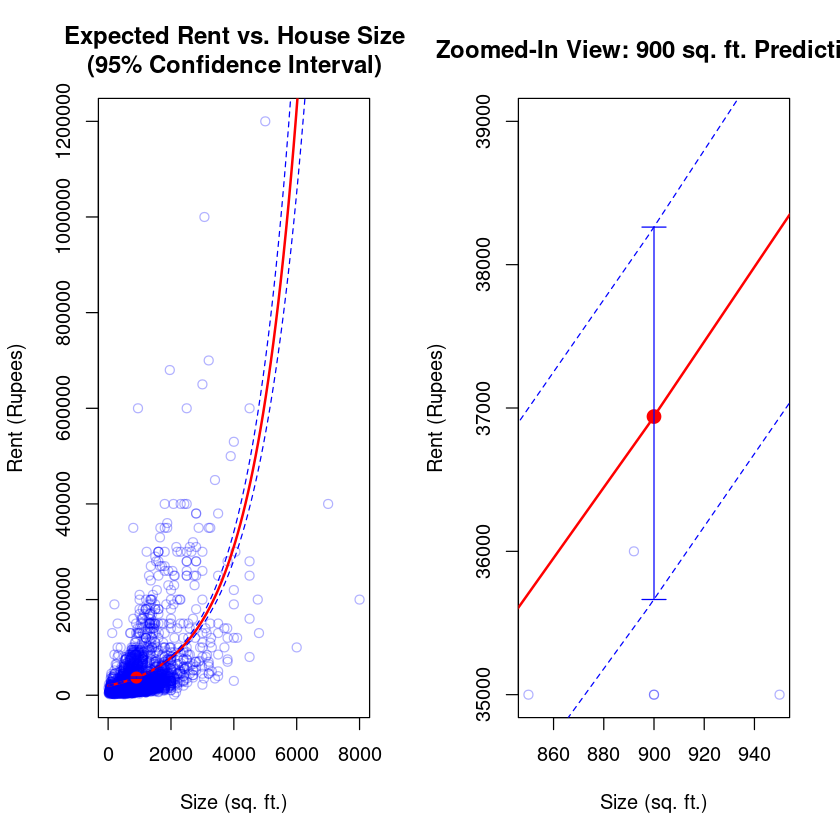

In [179]:
# Create sequence of house sizes for visualization
size_range <- data.frame(Size = seq(min(categorical_train$Size), max(categorical_train$Size), length.out = 100))

# Ensure factor levels match training set
size_range$Point.of.Contact <- factor("Contact Agent", levels = levels(categorical_train$Point.of.Contact))

# Predict log(Rent) with confidence interval
predictions_log <- predict(model_log, newdata = size_range, interval = "confidence")

# Convert back to actual rent prices
size_range$Rent <- exp(predictions_log[,1])  # Predicted Rent (converted from log)
size_range$Lower_CI <- exp(predictions_log[,2])  # Lower bound
size_range$Upper_CI <- exp(predictions_log[,3])  # Upper bound

# Define zoom-in range for subplot (around 900 sq. ft.)
zoom_x_range <- c(850, 950)  # X-axis range for zoom-in
zoom_y_range <- c(35000, 39000)  # Y-axis range for zoom-in

# Set up plotting space with two plots side by side
par(mfrow = c(1, 2))  # Set up 1 row, 2 columns for subplots

#Full View of Rent vs. Size
plot(categorical_train$Size, categorical_train$Rent,  
     pch = 1, col = rgb(0, 0, 1, 0.3),  
     main = "Expected Rent vs. House Size\n(95% Confidence Interval)",
     xlab = "Size (sq. ft.)", ylab = "Rent (Rupees)")

# Add regression line (predicted rent)
lines(size_range$Size, size_range$Rent, col = "red", lwd = 2)

# Add confidence interval
lines(size_range$Size, size_range$Lower_CI, col = "blue", lty = 2)
lines(size_range$Size, size_range$Upper_CI, col = "blue", lty = 2)

# Highlight the 900 sq. ft. prediction
points(900, 36940.26, col = "red", pch = 19, cex = 1.2)
arrows(900, 35664.05, 900, 38262.15, col = "blue", angle = 90, code = 3, length = 0.1)

#Zoomed-In View of 900 sq. ft.
plot(categorical_train$Size, categorical_train$Rent,  
     pch = 1, col = rgb(0, 0, 1, 0.3),  
     main = "Zoomed-In View: 900 sq. ft. Prediction",
     xlab = "Size (sq. ft.)", ylab = "Rent (Rupees)",
     xlim = zoom_x_range, ylim = zoom_y_range)

# Add regression line (predicted rent)
lines(size_range$Size, size_range$Rent, col = "red", lwd = 2)

# Add confidence interval
lines(size_range$Size, size_range$Lower_CI, col = "blue", lty = 2)
lines(size_range$Size, size_range$Upper_CI, col = "blue", lty = 2)

# Highlight the 900 sq. ft. prediction
points(900, 36940.26, col = "red", pch = 19, cex = 1.5)
arrows(900, 35664.05, 900, 38262.15, col = "blue", angle = 90, code = 3, length = 0.1)

# Reset plotting space to default
par(mfrow = c(1, 1))

The plots above show our confidence interval for our predictions and a zoomed-in version into our point of interest.

# Part IV: Summary

* **Objective:** We analyzed rental prices using real estate data. We developed predictive models to estimate Rent prices based on house size individually and added a point of contact (agent, owner, builder) as an extra predictor.
* **Findings:** The simple model underfits the data. On the other hand, a log transformation of the data makes the model overfit the data. Furthermore, Cross-validation revealed significant gaps between estimated and actual test-set MSE. This confirmed our concerns about the model's performance.
* **Actionable Insights:** To improve accuracy, we recommend incorporating more predictors (e.g., City, BHK, Furnishing Status) and, potentially, applying regularization techniques to reduce overfitting.
* **Next Steps:** Explore adding more features while maintaining simplicity for quick and actionable rental price predictions.

# AI Statement

I used Grammarly to proofread my assignment. Additionally, I used Chat-GPT to explore coding fixed, debugging issues and discussing result interpretation to get more nuanced insights.